# Pneumonia Classification with Deep Learning
## Multilayer Perceptrons

### Imports

In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers, regularizers
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense
from keras import layers
from keras.constraints import maxnorm

import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(7)

### Load Data

In [3]:
#create directories
main_dir = "../input/chest-xray-pneumonia/chest_xray/"

train_data_dir = main_dir + "train/"
val_data_dir = main_dir + "val/"
test_data_dir = main_dir + "test/"

train_norm = train_data_dir + 'NORMAL/'
train_pneum = train_data_dir + 'PNEUMONIA/'

val_norm = val_data_dir + 'NORMAL/'
val_pneum = val_data_dir + 'PNEUMONIA/'

test_norm = test_data_dir + 'NORMAL/'
test_pneum = test_data_dir + 'PNEUMONIA/'

os.listdir(main_dir)

['chest_xray', '__MACOSX', 'val', 'test', 'train']

In [4]:
print("Number of cases in training set:",len(os.listdir(train_pneum)) + len(os.listdir(train_norm)))
print("Number of cases in validation set:",len(os.listdir(val_pneum)) + len(os.listdir(val_norm)))
print("Number of cases in test set:",len(os.listdir(test_pneum)) + len(os.listdir(test_norm)))

Number of cases in training set: 5216
Number of cases in validation set: 16
Number of cases in test set: 624


In [5]:
#perform Image Augmentation to normalize and increase amount of data
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_dir, 
        target_size=(180, 180), batch_size = 624) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_data_dir, 
        target_size=(180, 180), batch_size = 16)

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir, 
        target_size=(180, 180), batch_size=5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


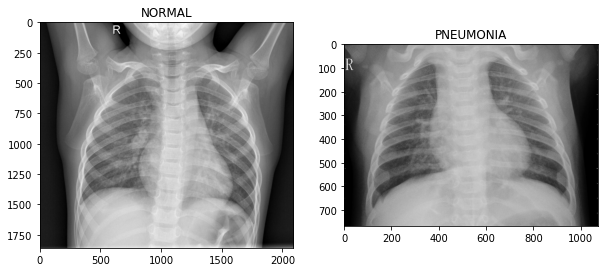

In [6]:
#samples from each class
sample_n = 'IM-0115-0001.jpeg'
img_normal = load_img(("../input/chest-xray-pneumonia/chest_xray/train/NORMAL/") + sample_n)

sample_p = 'person1000_virus_1681.jpeg'
img_pneumonia = load_img("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/" + sample_p)
    
fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(img_normal)
axs[0].set_title("NORMAL")
axs[1].imshow(img_pneumonia)
axs[1].set_title("PNEUMONIA");

In [7]:
#forming image and label datasets partitioned into train, test, and validation sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [8]:
#checking shapes for each set and class partitions
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 180, 180, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 180, 180, 3)
test_labels shape: (624, 2)
val_images shape: (16, 180, 180, 3)
val_labels shape: (16, 2)


In [9]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(5216, 97200)
(624, 97200)
(16, 97200)
(5216, 1)
(624, 1)
(16, 1)


In [10]:
# Creating variable for input_shape to save for models
mlp_input_shape = (97200,)

In [11]:
def visualize_training_results(results):
    
    """
    Function to visualize loss and accuracy across epochs. 
    Visualizes metrics specifically on training data.
    Will display metrics only within learned epochs (adheres to early callback).
    """
    
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [12]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

#### Sources for above code:
- [Feyza Ozkefe](https://www.kaggle.com/feyzazkefe/pneumonia-detection-using-cnn-89-42-acc)
- [Flatiron School](https://github.com/learn-co-curriculum/dsc-convolutional-neural-networks-codealong)

## Multilayer Perceptron

### Baseline MLP

In [13]:
train_img.shape

(5216, 97200)

In [14]:
mlp = Sequential()
mlp.add(Dense(64, activation='relu', input_shape=mlp_input_shape))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))

# output layer gets 1 node because this is binary classification 
# https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

mlp.compile(loss='binary_crossentropy',
           optimizer='Adam',
           metrics=['acc'])

mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                6220864   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 6,222,977
Trainable params: 6,222,977
Non-trainable params: 0
_________________________________________________________________


In [15]:
results_1 = mlp.fit(train_img, train_y, batch_size=16, epochs=12, validation_data=(test_img, test_y))

Epoch 1/12
326/326 [==============================] - 8s 22ms/step - loss: 1.1726 - acc: 0.7909 - val_loss: 2.1636 - val_acc: 0.7131
Epoch 2/12
326/326 [==============================] - 6s 19ms/step - loss: 0.4280 - acc: 0.9110 - val_loss: 1.6521 - val_acc: 0.7468
Epoch 3/12
326/326 [==============================] - 7s 20ms/step - loss: 0.2596 - acc: 0.9303 - val_loss: 0.5374 - val_acc: 0.8221
Epoch 4/12
326/326 [==============================] - 6s 19ms/step - loss: 0.1754 - acc: 0.9404 - val_loss: 1.2425 - val_acc: 0.7131
Epoch 5/12
326/326 [==============================] - 7s 20ms/step - loss: 0.2159 - acc: 0.9317 - val_loss: 1.0334 - val_acc: 0.7276
Epoch 6/12
326/326 [==============================] - 7s 20ms/step - loss: 0.1242 - acc: 0.9547 - val_loss: 1.4801 - val_acc: 0.6891
Epoch 7/12
326/326 [==============================] - 6s 20ms/step - loss: 0.1515 - acc: 0.9461 - val_loss: 1.2919 - val_acc: 0.6923
Epoch 8/12
326/326 [==============================] - 7s 21ms/step - 

In [16]:
train_scores = mlp.evaluate(train_img, train_y)
test_scores = mlp.evaluate(test_img, test_y)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

20/20 [==============================] - 0s 9ms/step - loss: 2.0515 - acc: 0.6779
Loss of the training model: 0.25
Training Accuracy: 91.22%


Loss of the testing model: 2.05
Test Accuracy: 67.79%


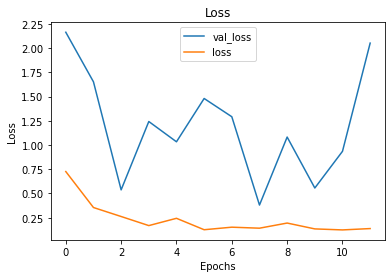

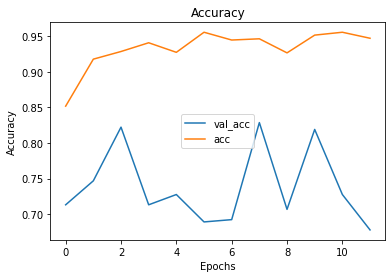

In [17]:
visualize_training_results(results_1)

First MLP is quite overfit. Previously, I experimented with different batch sizes and amount of epochs to see if they would mitigate overfitting, which they did not ([original source](https://www.kaggle.com/feyzazkefe/pneumonia-detection-using-cnn-89-42-acc)). I will try adding more layers, including a dropout layer, to the MLP to see if that may help.

In [18]:
mlp_2 = Sequential()
mlp_2.add(Dense(64, activation='relu', input_shape=mlp_input_shape))
mlp_2.add(Dense(48, activation='relu'))
mlp_2.add(Dense(32, activation='relu'))
mlp_2.add(Dense(16, activation='relu'))
mlp_2.add(Dropout(0.5))
mlp_2.add(Dense(1, activation='sigmoid'))

mlp_2.compile(loss='binary_crossentropy',
           optimizer='Adam',
           metrics=['acc'])

mlp_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                6220864   
_________________________________________________________________
dense_4 (Dense)              (None, 48)                3120      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1568      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 6,226,097
Trainable params: 6,226,097
Non-trainable params: 0
____________________________________________

In [19]:
results_2 = mlp_2.fit(train_img, train_y, batch_size=16, epochs=12, validation_data=(test_img, test_y))

Epoch 1/12
326/326 [==============================] - 7s 21ms/step - loss: 1.3676 - acc: 0.6946 - val_loss: 0.6347 - val_acc: 0.6282
Epoch 2/12
326/326 [==============================] - 6s 20ms/step - loss: 0.4482 - acc: 0.7824 - val_loss: 0.6995 - val_acc: 0.7340
Epoch 3/12
326/326 [==============================] - 6s 19ms/step - loss: 0.3446 - acc: 0.8612 - val_loss: 0.5203 - val_acc: 0.7724
Epoch 4/12
326/326 [==============================] - 6s 19ms/step - loss: 0.3259 - acc: 0.8909 - val_loss: 0.8972 - val_acc: 0.7163
Epoch 5/12
326/326 [==============================] - 7s 20ms/step - loss: 0.2860 - acc: 0.9052 - val_loss: 1.2489 - val_acc: 0.6506
Epoch 6/12
326/326 [==============================] - 6s 19ms/step - loss: 0.2741 - acc: 0.9075 - val_loss: 0.6383 - val_acc: 0.7131
Epoch 7/12
326/326 [==============================] - 6s 19ms/step - loss: 0.2377 - acc: 0.9232 - val_loss: 0.6951 - val_acc: 0.6955
Epoch 8/12
326/326 [==============================] - 6s 19ms/step - 

In [20]:
train_scores = mlp_2.evaluate(train_img, train_y)
test_scores = mlp_2.evaluate(test_img, test_y)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

20/20 [==============================] - 0s 9ms/step - loss: 0.5615 - acc: 0.7532
Loss of the training model: 0.12
Training Accuracy: 96.49%


Loss of the testing model: 0.56
Test Accuracy: 75.32%


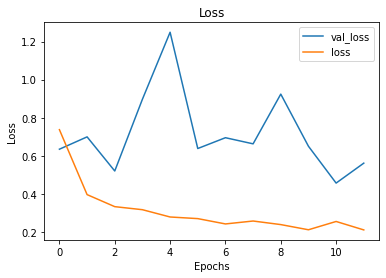

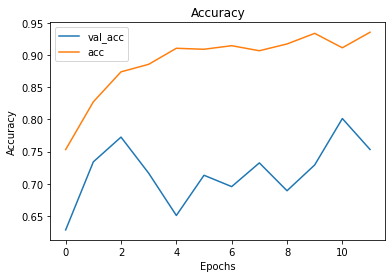

In [21]:
visualize_training_results(results_2)

I'll try adding more layers to see if that'll help performance.

In [22]:
mlp_3 = Sequential()

mlp_3.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.0005),
                kernel_constraint=maxnorm(5), input_shape=mlp_input_shape))
mlp_3.add(Dropout(0.5))

mlp_3.add(Dense(48, activation='relu'))
mlp_3.add(Dropout(0.5))

mlp_3.add(Dense(32, activation='relu'))
mlp_3.add(Dense(16, activation='relu'))

mlp_3.add(Dropout(0.2))
mlp_3.add(Dense(1, activation='sigmoid'))

mlp_3.compile(loss='binary_crossentropy',
           optimizer='Adam',
           metrics=['acc'])

mlp_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                6220864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 48)                3120      
_________________________________________________________________
dropout_2 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1568      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)               

In [23]:
results_3 = mlp_3.fit(train_img, train_y, batch_size=16, epochs=12,
                      callbacks=early_stopping_cb,
                      validation_data=(test_img, test_y))

Epoch 1/12
326/326 [==============================] - 17s 49ms/step - loss: 3.5114 - acc: 0.6845 - val_loss: 0.7183 - val_acc: 0.6250
Epoch 2/12
326/326 [==============================] - 15s 47ms/step - loss: 0.6420 - acc: 0.7289 - val_loss: 0.7148 - val_acc: 0.6250
Epoch 3/12
326/326 [==============================] - 16s 48ms/step - loss: 0.6021 - acc: 0.7399 - val_loss: 0.7072 - val_acc: 0.6250
Epoch 4/12
326/326 [==============================] - 15s 46ms/step - loss: 0.5814 - acc: 0.7495 - val_loss: 0.6958 - val_acc: 0.6250
Epoch 5/12
326/326 [==============================] - 16s 49ms/step - loss: 0.5945 - acc: 0.7359 - val_loss: 0.7045 - val_acc: 0.6250
Epoch 6/12
326/326 [==============================] - 16s 48ms/step - loss: 0.5872 - acc: 0.7399 - val_loss: 0.6991 - val_acc: 0.6250
Epoch 7/12
326/326 [==============================] - 20s 60ms/step - loss: 0.5803 - acc: 0.7395 - val_loss: 0.6961 - val_acc: 0.6250


In [24]:
train_scores = mlp_3.evaluate(train_img, train_y)
test_scores = mlp_3.evaluate(test_img, test_y)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

20/20 [==============================] - 0s 14ms/step - loss: 0.6958 - acc: 0.6250
Loss of the training model: 0.58
Training Accuracy: 74.29%


Loss of the testing model: 0.70
Test Accuracy: 62.50%


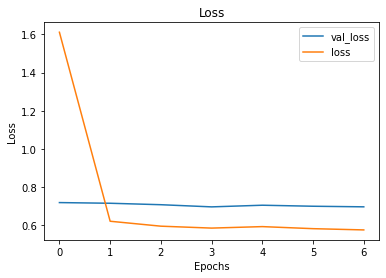

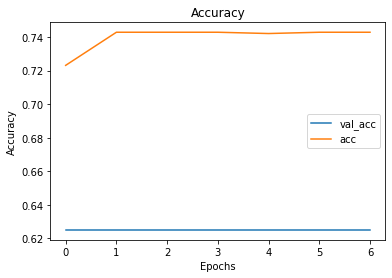

In [25]:
visualize_training_results(results_3)

I will try utilizing a CNN in another notebook to see if that will help with the model's overfitting and improving its testing accuracy.